<a href="https://colab.research.google.com/github/TomPhanAnh/Kaggle-Solution/blob/main/DaZone_Round2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# **ZALOPAY INTRODUCTION**

ZaloPay is an **E-wallet** established at the end of 2016 and is
part of Vietnamese unicorn VNG’s digital ecosystem, which
also includes gaming, media and cloud computing.

In January 2020, ZaloPay launched on Zalo platform, with the
aim to become the **“Vietnamese citizens’ E-wallet”.** ZaloPay
provides daily usage in-app services such as money transfer,
phone top-up, and paying bills. With a ready presence on local
users’ smartphones and robust product offerings, ZaloPay has
competitive advantages to become the champion e-wallet.

In May 2022, ZaloPay reached 10M active users, which was a
significant milestone. After a few years of traversing the
digital payment market, we have helped to foster a cashless
society by creating convenient payment methods for our
consumers' daily lives.

According to Circular 23/2019/TT-NHNN, each individual must accurately fill
out their personal information to validate their account and minimize risks
while making a payment. Before making payments for services, e-wallets must
be linked to the owner's bank account or debit card. As a result, ZaloPay has
always **prioritized the growth of associated banks and studying and optimizing
the flow of connecting banks to provide all clients with the most convenient
wallet.**

## **Context**

There are two systems of interest here: **front-end** and **back-end** systems. The **front-end system tracks **users’ interaction with the app (users stayed on
which screen, clicked on which button, at which time, etc.).The back-end
system** tracks the request in the back end that is created as a result of certain actions on the front-end. For example, when users clicked on the button “Mua ngay (buying immediately)” on an item, there’s a request on the backend at the same time and its status reflects whether users purchased successfully or not.

**For the front-end dataset:** Each screen in the product flow that you will
investigate in this assignment has its ID. The at-issues screens are numbered
from 11 to 18, where Screen 11 is the beginning of the flow where users will fill out their bank account info and click “Lien ket ngay (link immediately)” (see the illustrative at the end of the assignment). Screens 12 to 18 reflect different meanings (e.g. the outcomes of the “Lien ket ngay” action, and our
corresponding features for various outcomes).

**For the back-end dataset:** when users click “Liên kết ngay” on screenID 11,
a request will be recorded in the backend.csv. There are a lot of statuses here, but the one of interest is “-FACJ” status and “B”. When users encounter the “-FACJ” error, they will interact with another flow.

We are testing two UIs for users who encounter “-FACJ” error. Let’s call these
“new UI” and “old UI”. Only a subset of users can see the new UI, which includes
screenID 12, 13, 14, 15, 16, 17, 18. The old UI does not have an associated screenID, so it temporarily assumes users that have “-FACJ” error but don’t see screenID 12 through 18 will see the old UI.

The old UI and new UI are expected to help users retry and, hopefully, succeed.
Users that finish interacting with the flow after “-FACJ” will come back to
screenID 11 and submit another request to backend.csv. A successful request has
a “B” status.

###**Preprocessing dataset**

In [2]:
front_end = pd.read_csv("Front-end dataset.csv",delimiter = " ")
front_end = front_end['eventid\tid\tscreenid\ttimestamp\t\t\t,'].str.split("\t",expand = True)
front_end.drop([4,5,6], axis = 1, inplace = True)
front_end.columns = ["eventid","id","screenid","timestamp"]

In [3]:
def remove_comma(x):
  if "'" in x:
    return x.replace("'"," ").strip()
  else:
    return x
front_end["id"] = front_end["id"].apply(lambda x: remove_comma(x))
front_end["screenid"] = front_end["screenid"].apply(lambda x: remove_comma(x))
front_end["timestamp"] = front_end["timestamp"].apply(lambda x: remove_comma(x))

In [4]:
front_end["timestamp"] = pd.to_datetime(front_end["timestamp"],unit = "ms")

In [5]:
front_end.drop_duplicates(inplace = True)

## **Backend Dataset**

In [451]:
back_end = pd.read_csv("Back-end dataset.csv")
back_end = back_end['timestamp\tstepresult\tid'].str.split("\t",expand = True)
back_end.rename(columns = {0:"timestamp",1:"stepresult",2:"id"}, inplace =True)
back_end["timestamp"] = pd.to_datetime(back_end['timestamp'], unit = 'ms')

## **Merging Dataset**

In [7]:
# Create the dataset in order to count which UI has 2 or more than 2 and only 1
count_front = front_end.groupby(["id","screenid","eventid"]).agg({"eventid":"count"}).reset_index(level = [0,1])
max_front = count_front.groupby(["id","screenid"]).agg({"eventid":"max"}).reset_index().sort_values(["id","screenid"])

In [8]:
count_front.rename(columns = {"eventid":"count"},inplace = True)
count_front = count_front.reset_index()

In [9]:
merge_data = count_front.merge(front_end,on = ["eventid","id"], how = "right")
merge_data["screenid_x"] = merge_data["screenid_x"].astype("int64")

In [307]:
max_front.head()

,id,screenid,eventid
0,BAAAFACIBHCHHCCCAFH,11,1
1,BAAAFFHHEDJFEAAFG,11,3
2,BAABEBCJFBFDAGCHFAA,11,1
3,BAACEAADIJBJJCDDIII,11,1
4,BAACFAHHCDFIHAAACCG,11,1


In [11]:
# Create the dataset for screenid == 11
merge_data11 = merge_data.loc[merge_data["screenid_x"] == 11]
new_data = pd.DataFrame(columns = merge_data.columns)
for i in merge_data11["id"].value_counts().index:
  
  # Test the condition to take the most interactive eventid of old UI
  count = max(merge_data11.loc[(merge_data11["id"] == i)]["count"])
  eventid = merge_data11.loc[(merge_data11["id"] == i ) & 
                           (merge_data11["count"] == count)].sort_values(["timestamp","eventid"])["eventid"].value_counts().index[0]

  # Concatenate the Data with condition
  df = merge_data11.loc[(merge_data11["id"] == i) & 
                 (merge_data11["eventid"] == eventid)]  
            
  new_data = pd.concat([df,new_data])

In [12]:
# Create the dataset for screenid != 11
merge_data1218 = merge_data.loc[merge_data["screenid_x"] != 11]
new_data1218 = pd.DataFrame(columns = merge_data.columns)
for i in merge_data1218["id"].value_counts().index:

  # Test the condition to take the most interactive eventid of new UI
  count = max(merge_data1218.loc[(merge_data1218["id"] == i)]["count"])
  eventid = merge_data1218.loc[(merge_data1218["id"] == i ) & 
                           (merge_data1218["count"] == count)].sort_values(["timestamp","eventid"])["eventid"].value_counts().index[0]

  # Concatenate the Data with condition
  df = merge_data1218.loc[(merge_data1218["id"] == i) & 
                 (merge_data1218["eventid"] == eventid)]  
            
  new_data1218 = pd.concat([df,new_data1218])

In [13]:
# Concate to get timestamp for each loop
data_Q1 = pd.concat([new_data,new_data1218])

# **Task 1:Prepare a report that answers the following questions**

### **Q1. What is the retry rate for each UI? Does the new UI improve the retry rate?**

**Retry rate** = max(0,n_screen11 - n_screen1218 - 1)/

( max(0,n_screen11 - n_screen1218 - 1)+ n_screen1218)


**n_screen11:** the number of times UI log in

**n_screen1218:** the maximum number of times UI in each screen12 - 18 

*(**Assume:** user is interactive with several screen, the screen with the most use is chosen and 1 unit of other screen is equal as 1 unit of screen 11)*

#### **Prepare dataset**

In [14]:
# What is the retry rate for each UI? 
# 1 is new
# 0 is old
Q1 = data_Q1.drop_duplicates(["id","screenid_x"])

# create the dataframe to check UI old or new
question1 = pd.DataFrame(data_Q1["id"].value_counts().index, columns = ["id"])
question1["screen11"] = 0
question1["screen1218"] = 0


In [15]:
# Fill the dataset specified with each id (user)
for i in question1["id"].values:
  question1.loc[question1["id"] == i, "screen11"] = max_front.loc[(max_front["screenid"] == "11") & (max_front["id"] == i)]["eventid"].values
  try:
    question1.loc[question1["id"] == i, "screen1218"] = max(max_front.loc[(max_front["screenid"] != "11") & (max_front["id"] == i)]["eventid"].values)
  except:
    pass

In [16]:
# Define UI (New or Old)
question1["UI"] = question1.apply(lambda x: 1 if x["screen1218"] > 0 else 0, axis = 1)
question1["screen11"] = question1["screen11"].astype("int64")
question1["screen1218"] = question1["screen1218"].astype("int64")

# Calculate retry rate for each UI
# In case New UI enter in screen12 to screen 18 more than log-in (screen11) => no retry rate = 0
# Else New UI enter in screen12 to screen 18 less than log-in (screen11)    => retry rate is available
# The last time is not a retry (-1)
question1["retry_times"] = question1.apply(lambda x: max(0,x["screen11"] - x["screen1218"] - 1), axis = 1)

# retry rate of new_UI
new_iu_retry = sum(question1.loc[question1["UI"] == 1]['retry_times'])/(
                sum(question1.loc[question1["UI"] == 1]['retry_times']) 
              + sum(question1.loc[question1["UI"] == 1]["screen1218"]))

# Suppose the last time of old Ui does mean they stop => the last eventid doesn't mean a retry but a stop => don't include in the number of retry

# retry rate of old_UI
old_iu_retry = (sum(question1.loc[question1["UI"] == 0]['screen11']) -
                len(question1.loc[question1["UI"] == 0]['screen11']))/sum(question1.loc[question1["UI"] == 0]['screen11'])

#### **Answer T1.1: Result**

In [17]:
print("The retry rate of New UI: {}".format(round(new_iu_retry,2)))
print("The retry rate of Old UI: {}".format(round(old_iu_retry,2)))

The retry rate of New UI: 0.1
The retry rate of Old UI: 0.43


### **Q1.2: Does the new UI improve the retry rate?**

#### **Prepare dataset**

In [18]:
# Create the hour interval for frontend dataset
front_end["Year"]  = front_end["timestamp"].apply(lambda x: x.year)
front_end["Month"] = front_end["timestamp"].apply(lambda x: x.month)
front_end["Day"]   = front_end["timestamp"].apply(lambda x: x.day)
front_end["Hour"]  = front_end["timestamp"].apply(lambda x: x.hour)
front_end["timestamp2"] = front_end.apply(lambda x: pd.datetime(x["Year"],x["Month"],x["Day"],x["Hour"]), axis = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


In [19]:
Q12 = front_end.merge(question1[["id","UI"]], on = "id", how = "right")

In [20]:
Q12.head()

,eventid,id,screenid,timestamp,Year,Month,Day,Hour,timestamp2,UI
0,"x,11.xy1",FFDBDJFJGCIJHBBACIA,11,2021-03-15 08:17:27.824,2021,3,15,8,2021-03-15 08:00:00,1
1,"x,14.06",FFDBDJFJGCIJHBBACIA,14,2021-03-15 08:39:23.532,2021,3,15,8,2021-03-15 08:00:00,1
2,"x,11.xy0",FFDBDJFJGCIJHBBACIA,11,2021-03-15 08:17:28.822,2021,3,15,8,2021-03-15 08:00:00,1
3,"x,11.xy1",FFDBDJFJGCIJHBBACIA,11,2021-03-15 08:42:56.675,2021,3,15,8,2021-03-15 08:00:00,1
4,"x,14.06",FFDBDJFJGCIJHBBACIA,14,2021-03-15 08:43:10.081,2021,3,15,8,2021-03-15 08:00:00,1


In [21]:
Q12_sc11 = Q12.loc[(Q12["screenid"] == "11") 
                   & (Q12["UI"] == 1)].groupby(
                  by = ["timestamp2"]).count().reset_index()[["timestamp2","eventid"]].rename(columns = {"eventid":"screen11"})

In [22]:
Q12_sc1218 = pd.DataFrame(columns = ["timestamp2","eventid"])
table = Q12.loc[(Q12["screenid"] != "11") 
              & (Q12["UI"] == 1)].groupby(by = ["timestamp2","screenid"]).count().reset_index()

for i in table['timestamp2'].unique():        
  a = max(table.loc[table['timestamp2'] == i]["eventid"])
  table_x = table.loc[(table['timestamp2'] == i) 
                    & (table["eventid"] == a)][["timestamp2","eventid"]]
  Q12_sc1218 = pd.concat([Q12_sc1218,table_x]) 

In [23]:
Q12_sc1218.rename(columns = {"eventid":"screen1218"},inplace = True)

In [24]:
Q12_answer = Q12_sc11.merge(Q12_sc1218, on = "timestamp2", how = "left").fillna(0)
Q12_answer["retry_times"] = Q12_answer.apply(lambda x: max(0, x["screen11"] - x["screen1218"]), axis = 1)
Q12_answer["retry_rate"]  = Q12_answer.apply(lambda x: (x["retry_times"] - 1)/(x["retry_times"] + x["screen1218"]),axis = 1)
Q12_answer.drop(["screen11","screen1218"], axis = 1, inplace = True)

#### **Answer T1. Q1.2: Result**

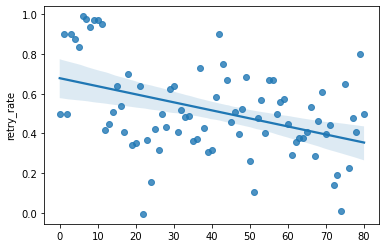

In [25]:
# Visualization of New UI by 1 hour interval from dataset with regression line
sns.regplot(x = Q12_answer.index, y = "retry_rate", data = Q12_answer)

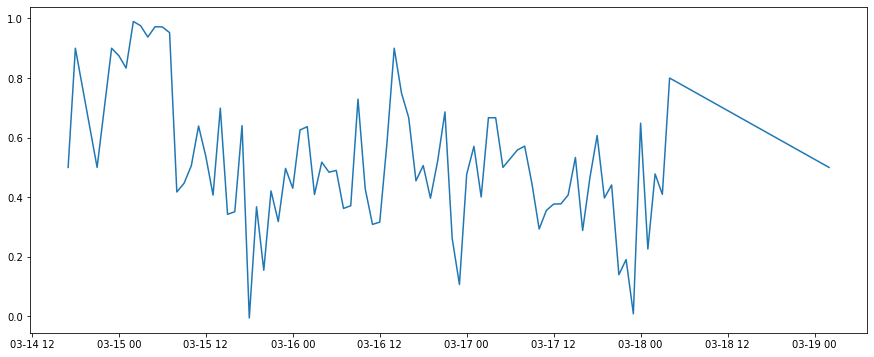

In [26]:
# Visualization of New UI by 1 hour interval from dataset with line chart
fig = plt.figure(figsize = (15,6))
plt.plot(Q12_answer["timestamp2"], Q12_answer["retry_rate"])

## **Q2. Among the people who retried, what is the success rate for each UI? Does the new UI improve the success rate?**

**Success rate** = min(n_success, n_enter)/n_enter

**n_success:** The number of time UI successfully reaches to screenID 12 - 18

**n_enter  :** The total number of time UI enter in screen 11

In [27]:
question1["success_times"] = question1.apply(lambda x: min(x["screen1218"],x["screen11"]), axis = 1)
question1["success_rate"]  = question1.apply(lambda x: x["success_times"]/x["screen11"], axis = 1)

In [28]:
new_iu_success = sum(question1.loc[question1["UI"] == 1]['success_times'])/(sum(question1.loc[question1["UI"] == 1]["screen11"]))
old_iu_success = sum(question1.loc[question1["UI"] == 0]['success_times'])/(sum(question1.loc[question1["UI"] == 0]["screen11"]))

#### **Answer T1. Q2.1: Result**

In [29]:
print("The success rate of New UI: {}".format(round(new_iu_success,2)))
print("The success rate of Old UI: {}".format(old_iu_success))

The success rate of New UI: 0.75
The success rate of Old UI: 0.0


### **Q2.2. Does the new UI improve the success rate?**

In [30]:
Q22 = Q12_sc11.merge(Q12_sc1218, on = "timestamp2", how = "left").fillna(0)
Q22.head()

,timestamp2,screen11,screen1218
0,2021-03-14 17:00:00,2,0
1,2021-03-14 18:00:00,10,0
2,2021-03-14 21:00:00,2,0
3,2021-03-14 23:00:00,10,0
4,2021-03-15 00:00:00,8,0


In [31]:
Q22["success_times"] = Q22.apply(lambda x: min(x["screen1218"],x["screen11"]), axis = 1)
Q22["success_rate"]  = Q22.apply(lambda x: x["success_times"]/x["screen11"], axis = 1)
Q22.drop(["screen11","screen1218"], axis = 1, inplace = True)

#### **Answer T1. Q2.2: Result**

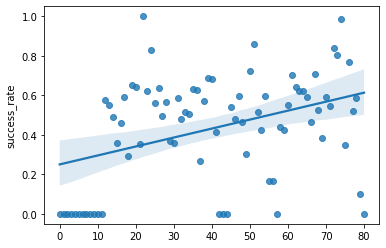

In [32]:
# Visualization of New UI by 1 hour interval from dataset
sns.regplot(x = Q22.index, y = "success_rate", data = Q22)

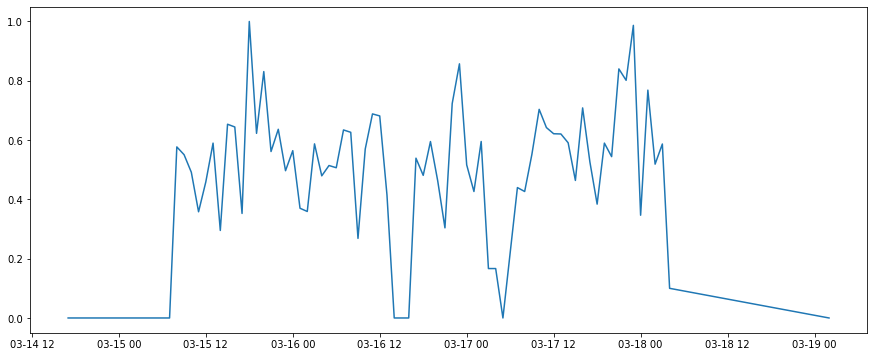

In [33]:
# Visualization of New UI by 1 hour interval from dataset with line chart
fig = plt.figure(figsize = (15,6))
plt.plot(Q22["timestamp2"], Q22["success_rate"])

##**Q3. What is the distribution of requests by the error for each UI? Does the new UI help reduce FACJ error?**

**Q3.1 What is the distribution of requests by the error for each UI?**

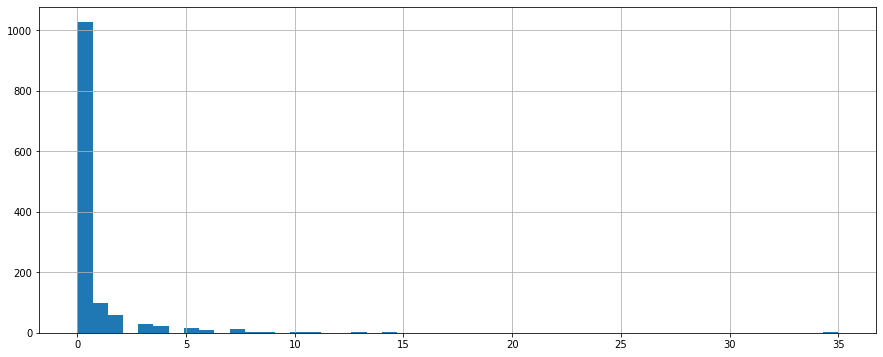

In [34]:
Q31 = question1.copy()
# Visualize The distribution in term of retry times of New UI (UI = 1)
fig = plt.figure(figsize = (15,6))
Q31.loc[Q31["UI"] == 1]["retry_times"].hist(bins = 50)

In [289]:
Q31.loc[Q31["UI"] == 1]["retry_times"].value_counts()

0     1027
1      100
2       58
3       29
4       22
5       15
7       11
6        9
8        2
35       1
14       1
13       1
11       1
10       1
9        1
Name: retry_times, dtype: int64

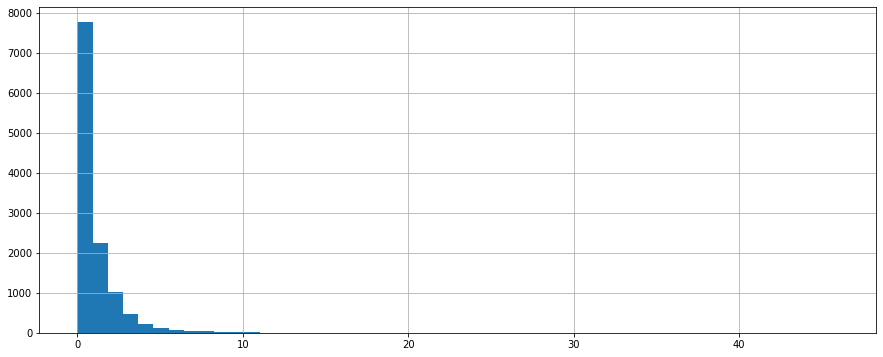

In [35]:
Q31 = question1.copy()
# Visualize The distribution in term of retry times of Old UI (UI = 0)
fig = plt.figure(figsize = (15,6))
Q31.loc[Q31["UI"] == 0]["retry_times"].hist(bins = 50)

In [287]:
Q31.loc[Q31["UI"] == 0]["retry_times"].value_counts()

0     7761
1     2256
2     1026
3      480
4      228
5      118
6       64
7       49
8       33
10      18
9       15
11      11
12       7
14       6
13       4
17       3
19       3
31       1
15       1
16       1
20       1
24       1
28       1
30       1
46       1
Name: retry_times, dtype: int64

**Q.3.2.Does the new UI help reduce FACJ error?**

In [36]:
pd.concat([Q31.loc[Q31["UI"] == 0]["retry_times"].describe().to_frame().rename(columns = {"retry_times":"Old UI"}),
           
           Q31.loc[Q31["UI"] == 1]["retry_times"].describe().to_frame().rename(columns = {"retry_times":"New UI"})], axis = 1)

,Old UI,New UI
count,12090.000000,1279.000000
mean,0.762200,0.551212
std,1.638253,1.727617
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,0.000000
max,46.000000,35.000000


## **Q4. Among users that have eventid “x,13.02” , what is the ratio that has “x,14.05”**

In [37]:
len(front_end.loc[(front_end["eventid"] == "x,13.02") & (front_end["id"] == "BFHEHIDBJEJDABIAFBE")])

5

In [38]:
Q4 = pd.DataFrame(columns = ["id","x,13.02","x,14.05"])
Q4['id'] = front_end[front_end["eventid"] == "x,13.02"]["id"].value_counts().index


In [39]:
for i in Q4["id"].values:
  Q4.loc[Q4["id"] == i , "x,13.02"] = len(front_end.loc[(front_end["eventid"] == "x,13.02") & (front_end["id"] == i)])
  try:
    Q4.loc[Q4["id"] == i , "x,14.05"] = len(front_end.loc[(front_end["eventid"] == "x,14.05") & (front_end["id"] == i)])
  except:
    pass

In [40]:
# Column available indicates 1 if x,14.05 in eventid: x,13.02 
Q4["available"] = Q4.apply(lambda x: 1 if min(x["x,13.02"],x["x,14.05"]) > 0 else 0, axis = 1)

#### **Answer T1. Q4: Result**

In [41]:
ratio = Q4["available"].value_counts()[1]/sum(Q4["available"].value_counts())
print("Among users that have eventid “x,13.02” , the ratio that has “x,14.05” is: {}".format(round(ratio,2)))

Among users that have eventid “x,13.02” , the ratio that has “x,14.05” is: 0.72


## **Q5. Do we keep or remove this product feature (new UI)? If we keep it, what should be optimized?**

In [207]:
Q5 = Q12[Q12["UI"]  == 1].groupby(['screenid','eventid']).count().reset_index(level = [0,1])[['screenid','eventid','id']]

In [248]:
Q5_describe = Q5.groupby('screenid').describe().reset_index()["id"].rename(columns = {"count":"screenid"})
Q5_describe["screenid"] = [11,12,13,14,15,16,17,18]

In [251]:
# Define the outlier of each screen (number of time click to show whether they are extremely under interactive or over interactive)
Q5_describe["outlier_min"] = Q5_describe['25%'] - 1.5*(Q5_describe["75%"] - Q5_describe["25%"])
Q5_describe["outlier_max"] = Q5_describe['75%'] + 1.5*(Q5_describe["75%"] - Q5_describe["25%"])

In [263]:
Q5["screenid"] = Q5["screenid"].astype("int64")
Q5_answer = Q5.merge(Q5_describe[["screenid","outlier_min","outlier_max"]], on = "screenid")
Q5_answer["Q5"] = Q5_answer.apply(lambda x:  "reject" if (x["id"] > x["outlier_max"]) or (x["id"] < x["outlier_min"]) else "keep", axis = 1)


#### **Answer T1. Q5: Result**

In [269]:
# The eventid/feature should removed from apps ZaloPay
Q5_answer[Q5_answer["Q5"] == "reject"]["eventid"].values

array(['x,11.xy0', 'x,11.xy6', 'x,14.02', 'x,16.02'], dtype=object)

# **Task 2: Additionally, do the following ad-hoc checks on the data (no need to include these in the report, but good to include in the summary email)**

## **Q1. In metadata.csv, extract the bank code from metadata column.**
For example, >>> '{"timeStamp":1628391863136, "osType":2, "bankCode":"AHG"}' AHG

**How many unique banks are there?**

In [42]:
metadata = pd.read_csv("Meta dataset.csv")
metadata = metadata["metadata"].str.split(",",expand = True)
metadata.columns = ["timestamp","osType","bankcode"]
# Extract data from row with string technique
metadata["timestamp"] = metadata["timestamp"].apply(lambda x: int(x[-13:]))
metadata["osType"]    = metadata["osType"].apply(lambda x: int(x[-1:]))
metadata["bankcode"]  = metadata["bankcode"].apply(lambda x: x[-5:-2].upper())

In [43]:
metadata.loc[metadata["bankcode"] == '"RG', "bankcode"] = "RG"

#### **Answer T2.1: Result**

In [44]:
print("The number of Unique bank are: {}".format(len(metadata["bankcode"].value_counts())))

The number of Unique bank are: 39


## **Q2. In backend.csv, determine the year, month, and date of the log.**

-FACJ1 > B1 > -FACJ2 > B2

**Then their weighted time will be the average of -FACJ1 to B1 and -FACJ2 to B2.**

In [452]:
# Seperate the dataset into 2 dataset base on stepreselt()
# back_end_avail is stepresult == "B"
# back_end_avail is stepresult != B
back_end_avail = back_end[back_end["stepresult"] == "B"]
back_end_name  = back_end[back_end["stepresult"] != "B"]

#### **Function for Task 2. Q2**

In [398]:
from numpy.ma.core import zeros
# shift_day is the function working as shift day back 1 day of 1 UI
def shift_day(x,y,z):
  if x != y:
    return None
  else:
    return z

# Shift status is the function to work as shift status back 1 day of 1 UI
def shift_status(x,y,z):
  if x != y:
    return None
  else:
    return z

# return accept is the function to define status "B" or status "FACJ"
def return_accept(id,timestamp,timestamp1):
  if pd.isnull(timestamp1):
    accept = front_end.loc[(front_end["id"] == id) & (front_end["timestamp"] <= timestamp)]["screenid"].nunique()
  else:
    accept = front_end.loc[(front_end["id"] == id) & (front_end["timestamp"] >= timestamp1) & (front_end["timestamp"] <= timestamp)]["screenid"].nunique()
  if accept > 1:
    return "B"
  else:
    return "FACJ"
# weighted_time is to calculate the weighted time of each UI
from datetime import datetime

def weighted_time(x,y):
  if x == "B" and y == "FACJ":
    return True
  elif x == "FACJ" and y == "FACJ":
    return False
  elif x == "FACJ" and y == "B":
    return None
  else:
    return None



#### **Reprepare backend dataset**

In [453]:
back_end_name["id_1"] = back_end_name["id"].shift(1)
back_end_name["timestamp_1"] = back_end_name["timestamp"].shift(1)
back_end_name["timestamp_1"] = back_end_name.apply(lambda x: shift_day(x["id"],x["id_1"],x["timestamp_1"]),axis = 1)

# Redefince the stepresult columns
back_end_name["stepresult"] = back_end_name.apply(lambda x: return_accept(x["id"],x["timestamp"],x["timestamp_1"]), axis = 1)

# Create the stepresult back 1 days to check weighted time
back_end_name["stepresult_1"] = back_end_name["stepresult"].shift(1)
back_end_name["stepresult_1"] = back_end_name.apply(lambda x: shift_status(x["id"],x["id_1"],x["stepresult_1"]), axis = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [454]:
back_end_avail["id_1"] = back_end_avail["id"].shift(1)
back_end_avail["timestamp_1"] = back_end_avail["timestamp"].shift(1)
back_end_avail["timestamp_1"] = back_end_avail.apply(lambda x: shift_day(x["id"],x["id_1"],x["timestamp_1"]),axis = 1)

# Create the stepresult back 1 days to check weighted time
back_end_avail["stepresult_1"] = back_end_avail["stepresult"].shift(1)
back_end_avail["stepresult_1"] = back_end_avail.apply(lambda x: shift_status(x["id"],x["id_1"],x["stepresult_1"]), axis = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [455]:
# Concatenate the dataset to get the new back_end which has already fulfilled the stepresult
back_end = pd.concat([back_end_name,back_end_avail])
# Drop duplicates
back_end.drop_duplicates(["timestamp","id"],inplace = True)

# Remove id has only 1 row because the average time is calculated only when 2 or more rows are availble
# index with only 1 row are 
new = back_end["id"].value_counts()[back_end["id"].value_counts() == 1].index

back_end = back_end.set_index("id").drop(new, axis = 0).reset_index()
back_end.drop_duplicates()
back_end.dropna(axis = 0, inplace = True)

### **Continue**

In [456]:
import time
# Change time columns into second
back_end["timestamp"] = back_end["timestamp"].apply(lambda x: time.mktime(x.timetuple()))
back_end["timestamp_1"]= back_end["timestamp_1"].apply(lambda x: time.mktime(x.timetuple()))
back_end["diff_time_second"] = back_end["timestamp"] - back_end["timestamp_1"]


In [457]:
# Create the null dataframe with Id has column available with status "B" 
back_end_T22 = pd.DataFrame(columns = [i for i in back_end.loc[back_end["stepresult"] == "B"]["id"].unique()])
back_end_T22["time_values"] = 0
back_end_T22["time_values"] = np.arange(0,5)

# Fill Null data
for i in back_end_T22.columns[:-1]:
  back_end_T22[i] = None

In [458]:
# Fill data of each row with specific value from back_end and back_end_T22 datasets
for x,y in zip([i for i in back_end_T22.columns[:-1]],range(len(back_end_T22.columns[:-1]))):
  n = 0
  table  = back_end.loc[back_end["id"] == x]
  number = len(table)
  # Divide into 2 situation: len of table == 1 and > 1
  if number > 1:
    for j in range(number):
      table_T22 = table.iloc[j]
      # N is for situation that if UI face 2 or more status "FACJ" respectively then we sum them until meet status "B"
      if weighted_time(table_T22["stepresult"],table_T22["stepresult_1"]):
        back_end_T22.iloc[j,y] = n + table_T22["diff_time_second"]
        n = 0
      else:
      # In case, only 1, we check is the condition satisfied? No => None, Yes => diff_time_second
        n += table_T22["diff_time_second"]
  else:
    if weighted_time(table_T22["stepresult"],table_T22["stepresult_1"]):
      back_end_T22.iloc[j,y] = table_T22["diff_time_second"]
    else:
      back_end_T22.iloc[j,y] = None
    
      
# Transpose dateset back_end_T22
back_end_T22  = back_end_T22.T

# Rename columns and fill data None with Null value
back_end_T22 = back_end_T22.reset_index().rename(columns = {"index":"UI"})
back_end_T22.fillna(np.nan, inplace = True)

In [459]:
back_end_T22 = back_end_T22.reset_index().rename(columns = {"index":"UI"})
back_end_T22.fillna(np.nan, inplace = True)


In [486]:
back_end_T22["Average"] = back_end_T22["UI"].apply(lambda x: np.nanmean([i for i in back_end_T22[back_end_T22["UI"] == x].values[0][1:]]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


### **Answer T2.2: Average**

In [497]:
# Answer for Q5
back_end_T22[["UI","Average"]].dropna(axis = 0).iloc[:-1,:]

,UI,Average
2,CHDDDBJDDFECIBAFBCF,90000.0
3,DJAFCBCGBDIBIEIBGJC,10000.0
4,JFCHIGJCDDHADCFAIJF,70000.0
8,CGBBIGFHGCDHIEABGCA,10000.0
10,JGEEACEAGBHBCGBAJCE,10000.0
19,IJAAJHDHFABBIBJCEJD,20000.0
27,IBICHCHJGBCDFEIFGAF,30000.0
28,BFDDCBJCIJAFIDDHFJI,10000.0
29,CEGCEIGEIADAICDEJJF,10000.0
30,BICDJCEGCAIHCHBHDBH,10000.0


# No touch

In [502]:
metadata.head()

,timestamp,osType,bankcode
0,1628391863136,2,AHG
1,1628391869377,2,AUG
2,1628391874924,2,AUG
3,1628436403665,2,NIA
4,1628412799080,2,ANG
